In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, f1_score, recall_score, precision_score, ConfusionMatrixDisplay

from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings('ignore')

In [ ]:
main = pd.read_csv('df_train.csv')
test = pd.read_csv('df_test.csv')
df = main.copy()

In [ ]:
df_contacted = df.loc[df['prev_contacted']=="no",:]
test_contacted = test.loc[test['prev_contacted']=="no",:]

In [ ]:
df_contacted.shape,test_contacted.shape

((29463, 18), (7414, 18))

In [ ]:
#checking class unbalance
df_contacted['subscribed'].value_counts(),test_contacted['subscribed'].value_counts()

(subscribed
 no     26760
 yes     2703
 Name: count, dtype: int64,
 subscribed
 no     6746
 yes     668
 Name: count, dtype: int64)

In [ ]:
drop_columns = ['prev_contacted','day','pdays','previous','poutcome']

In [ ]:
df_contacted = df_contacted.drop(columns=drop_columns,axis=1)
test_contacted = test_contacted.drop(columns=drop_columns,axis=1)

In [ ]:
df_contacted['subscribed'] = np.where(df_contacted['subscribed']=='no',0,1)
test_contacted['subscribed'] = np.where(test_contacted['subscribed']=='no',0,1)

In [ ]:
df_contacted.info(), test_contacted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29463 entries, 0 to 36153
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         29463 non-null  float64
 1   job         29463 non-null  object 
 2   marital     29463 non-null  object 
 3   education   29463 non-null  object 
 4   default     29463 non-null  object 
 5   balance     29463 non-null  float64
 6   housing     29463 non-null  object 
 7   loan        29463 non-null  object 
 8   contact     29463 non-null  object 
 9   month       29463 non-null  object 
 10  duration    29463 non-null  int64  
 11  campaign    29463 non-null  int64  
 12  subscribed  29463 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 7414 entries, 0 to 9034
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         7414 non-null   fl

(None, None)

In [ ]:
#checking Duplicates
df_contacted.duplicated().sum(), test_contacted.duplicated().sum()

(0, 0)

In [ ]:
#checking null
df_contacted.isnull().sum(), test_contacted.isnull().sum()

(age           0
 job           0
 marital       0
 education     0
 default       0
 balance       0
 housing       0
 loan          0
 contact       0
 month         0
 duration      0
 campaign      0
 subscribed    0
 dtype: int64,
 age           0
 job           0
 marital       0
 education     0
 default       0
 balance       0
 housing       0
 loan          0
 contact       0
 month         0
 duration      0
 campaign      0
 subscribed    0
 dtype: int64)

In [ ]:
#train test split
X_train=df_contacted.drop(columns=['subscribed'])
y_train=df_contacted['subscribed']
X_test=test_contacted.drop(columns=['subscribed'])
y_test=test_contacted['subscribed']

In [ ]:
#Preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

ords = ['education']
noms = ['job','marital','default','housing','loan','contact','month']
quants = ['age','balance','duration','campaign']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal',OrdinalEncoder(),ords),
        ('noms',OneHotEncoder(sparse_output=False),noms),
        ('quants',StandardScaler(),quants)
    ]
)

preprocessor_pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
    ]
)

# Without Resampling (Unbalanced case)

## Logistic Regression (Base Model)

In [ ]:
model_pipline = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',LogisticRegression())
    ]
)

model_pipline.fit(X_train,y_train)

y_preds = model_pipline.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6746
           1       0.57      0.27      0.37       668

    accuracy                           0.92      7414
   macro avg       0.75      0.63      0.66      7414
weighted avg       0.90      0.92      0.90      7414

AUC-ROC Score: 0.7521


In [ ]:
#training accuracy
y_preds_train = model_pipline.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     26760
           1       0.62      0.28      0.39      2703

    accuracy                           0.92     29463
   macro avg       0.77      0.63      0.67     29463
weighted avg       0.90      0.92      0.90     29463



Text(0.5, 0, 'Predicted Label')

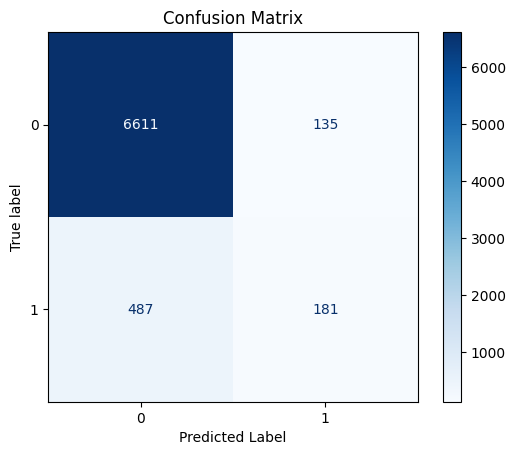

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### Assumption Check

In [ ]:
# Needed to run the logistic regression
import statsmodels.formula.api as smf

# For plotting/checking assumptions
import seaborn as sns

In [ ]:
X_train[noms] = X_train[noms].astype('category')
X_train[ords] = X_train[ords].astype('category')
X_test[noms]=X_test[noms].astype('category')
X_test[ords]=X_test[ords].astype('category')

In [ ]:
X_train1= pd.get_dummies(X_train)
X_test1= pd.get_dummies(X_test)

In [ ]:
df_train1=pd.concat([X_train,y_train],axis=1)
df_test1=pd.concat([X_test,y_test],axis=1)


In [ ]:
df_train1.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'month', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'subscribed'],
      dtype='object')

In [ ]:
model= smf.logit(formula="subscribed~age+C(job)+C(marital)+C(education)+C(default)+balance+C(housing)+C(loan)+C(contact)+C(month)+duration+campaign+pdays+previous+C(poutcome)", data= df_train1).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.351324
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             subscribed   No. Observations:                 6691
Model:                          Logit   Df Residuals:                     6649
Method:                           MLE   Df Model:                           41
Date:                Tue, 20 Aug 2024   Pseudo R-squ.:                  0.3457
Time:                        13:19:56   Log-Likelihood:                -2350.7
converged:                       True   LL-Null:                       -3592.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.9735      0.336     -8.841      0.000      -3.633      -2.314
C(job)[T.blue-collar]        -0.4267      0.154     -2.776      0.006      -0.728      -0.125
C(job)[T.entrepreneur]       -0.9158      0.322     -2.841      0.004      -1.548      -0.284
C(job)[T.housemaid]           0.0133      0.275      0.048      0.962      -0.526       0.552
C(job)[T.management]          0.0072      0.146      0.050      0.960      -0.279       0.294
C(job)[T.retired]            -0.0293      0.203     -0.144      0.885      -0.427       0.368
C(job)[T.self-employed]      -0.2193      0.227     -0.968      0.333      -0.664       0.225
C(job)[T.services]           -0.0895      0.173     -0.519      0.604      -0.428       0.249
C(job)[T.student]             0.1781      0.205      0.871      0.384      -0.223       0.579
C(job)[T.technician]         -0.1773      0.140     -1.271      0.204      -0.451       0.096
C(job)[T.unemployed]          0.3535      0.236      1.497      0.134      -0.109       0.816
C(job)[T.unknown]             0.0470      0.488      0.096      0.923      -0.910       1.004
C(marital)[T.married]         0.1225      0.126      0.972      0.331      -0.125       0.370
C(marital)[T.single]          0.1514      0.144      1.049      0.294      -0.132       0.434
C(education)[T.secondary]     0.1209      0.138      0.873      0.383      -0.151       0.392
C(education)[T.tertiary]      0.2792      0.159      1.760      0.078      -0.032       0.590
C(education)[T.unknown]       0.3790      0.215      1.761      0.078      -0.043       0.801
C(default)[T.yes]            -0.2422      0.574     -0.422      0.673      -1.368       0.883
C(housing)[T.yes]            -0.7095      0.088     -8.069      0.000      -0.882      -0.537
C(loan)[T.yes]               -0.3534      0.132     -2.685      0.007      -0.611      -0.095
C(contact)[T.telephone]      -0.3987      0.152     -2.623      0.009      -0.697      -0.101
C(contact)[T.unknown]        -0.3063      0.401     -0.763      0.445      -1.093       0.480
C(month)[T.aug]               0.9218      0.163      5.643      0.000       0.602       1.242
C(month)[T.dec]               0.4967      0.282      1.759      0.079      -0.057       1.050
C(month)[T.feb]               0.1864      0.157      1.190      0.234      -0.120       0.493
C(month)[T.jan]              -0.5388      0.211     -2.559      0.011      -0.951      -0.126
C(month)[T.jul]               1.1842      0.211      5.616      0.000       0.771       1.597
C(month)[T.jun]               0.9509      0.189      5.038      0.000       0.581       1.321
C(month)[T.mar]               1.2549      0.231      5.436      0.000       0.802       1.707
C(month)[T.may]              -0.2083      0.134     -1.556      0.120      -0.471       0.054
C(month)[T.nov]              -0.2307      0.157     -1.468      0.142      -0.539       0.077
C(month)[T.oct]               0.9824      0.1

In [ ]:
df_train2=pd.concat([X_train1,y_train],axis=1)
df_test2=pd.concat([X_test1,y_test],axis=1)

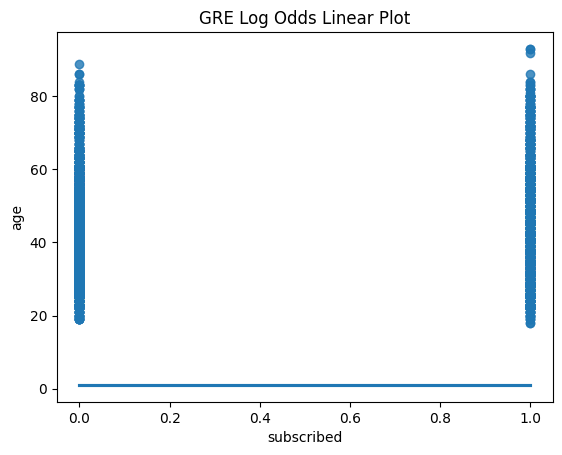

In [ ]:
gre = sns.regplot(x= 'subscribed', y= 'age', data= df_train2, logistic= True).set_title("GRE Log Odds Linear Plot")


In [ ]:
df_train2.corr()

age   balance  duration  campaign     pdays  \
age                  1.000000  0.115704  0.069315  0.006017 -0.102903   
balance              0.115704  1.000000  0.044152  0.002162 -0.099819   
duration             0.069315  0.044152  1.000000 -0.088340 -0.036626   
campaign             0.006017  0.002162 -0.088340  1.000000  0.047849   
pdays               -0.102903 -0.099819 -0.036626  0.047849  1.000000   
previous             0.003288  0.006784 -0.010469  0.182131 -0.030586   
job_admin.          -0.059045 -0.045123 -0.027738 -0.022129  0.022237   
job_blue-collar     -0.072184 -0.069576 -0.027555  0.038026  0.191983   
job_entrepreneur     0.015114 -0.017549  0.011526  0.029846 -0.003352   
job_housemaid        0.089130  0.013391 -0.013997  0.008900 -0.044199   
job_management      -0.025961  0.078038 -0.002455 -0.010783 -0.094114   
job_retired          0.557677  0.091504  0.078206 -0.034773 -0.110776   
job_self-employed   -0.016618  0.028400  0.015507 -0.012759 -0.037742   
job_services        -0.071531 -0.044392  0.000982  0.013442  0.075959   
job_student         -0.238073 -0.002057 -0.008294  0.011810 -0.062009   
job_technician      -0.062844 -0.004277 -0.013515 -0.003713 -0.032535   
job_unemployed      -0.006477 -0.008475  0.029396 -0.011233 -0.007333   
job_unknown          0.045535  0.000099  0.022538 -0.019710 -0.015813   
marital_divorced     0.162216 -0.000627  0.010448 -0.000730  0.028388   
marital_married      0.309490  0.029745  0.011838  0.004794 -0.003198   
marital_single      -0.441270 -0.031262 -0.019796 -0.004607 -0.016106   
education_primary    0.208167 -0.013567  0.026884  0.011122  0.058715   
education_secondary -0.089140 -0.086392 -0.030667  0.011864  0.107716   
education_tertiary  -0.084410  0.097746  0.009617 -0.020749 -0.150065   
education_unknown    0.078573  0.010843  0.010192  0.000365 -0.016943   
default_no           0.026279  0.046083  0.000706  0.001139 -0.026566   
default_yes         -0.026279 -0.046083 -0.000706 -0.001139  0.026566   
housing_no           0.184497  0.105382  0.077441 -0.062091 -0.324392   
housing_yes         -0.184497 -0.105382 -0.077441  0.062091  0.324392   
loan_no              0.013334  0.088005  0.036771 -0.004048 -0.022263   
loan_yes            -0.013334 -0.088005 -0.036771  0.004048  0.022263   
contact_cellular    -0.191422 -0.027218  0.027125 -0.098201 -0.032673   
contact_telephone    0.201132  0.032004 -0.007421  0.122003 -0.021829   
contact_unknown      0.000574 -0.009512 -0.059460 -0.052722  0.158291   
month_apr           -0.045397 -0.005957  0.058198 -0.037943  0.083576   
month_aug            0.013279  0.016250  0.000971 -0.037754 -0.106585   
month_dec            0.024959  0.055559  0.047440  0.029694 -0.028789   
month_feb            0.027624 -0.030404 -0.023739  0.042039 -0.078069   
month_jan            0.039475 -0.044917 -0.031630 -0.050187 -0.073148   
month_jul            0.035699  0.017311  0.037818  0.000955  0.017714   
month_jun           -0.000979  0.027610  0.015124 -0.034023 -0.098339   
month_mar            0.030280  0.026432 -0.003878 -0.009090 -0.026225   
month_may           -0.113489 -0.085718 -0.039345  0.114119  0.374037   
month_nov            0.034635  0.077477 -0.036933 -0.028444 -0.263434   
month_oct            0.067535  0.036691  0.024853 -0.056037 -0.076911   
month_sep            0.041474  0.025659  0.033988 -0.032731 -0.015675   
poutcome_failure    -0.022914 -0.040291 -0.077149 -0.054035  0.172676   
poutcome_other      -0.052997 -0.006661 -0.015336  0.137700  0.023292   
poutcome_success     0.087040  0.058979  0.114303 -0.080607 -0.245661   
poutcome_unknown    -0.004297 -0.004785  0.013360  0.002906 -0.001617   
subscribed           0.084903  0.074594  0.340103 -0.090377 -0.155889   

                     previous  job_admin.  job_blue-collar  job_entrepreneur  \
age                  0.003288   -0.059045        -0.072184          0.015114   
balance              0.006784   -0.045123        -0.069576         -0

## Banging Techniques and Ensembled Techniques


### Starndard Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
model_pipline2 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',BaggingClassifier(random_state=123))
    ]
)

model_pipline2.fit(X_train,y_train)

y_preds = model_pipline2.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6746
           1       0.79      0.64      0.70       668

    accuracy                           0.95      7414
   macro avg       0.88      0.81      0.84      7414
weighted avg       0.95      0.95      0.95      7414

AUC-ROC Score: 0.8773


In [ ]:
#training accuracy
y_preds_train = model_pipline2.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26760
           1       0.99      0.92      0.96      2703

    accuracy                           0.99     29463
   macro avg       0.99      0.96      0.98     29463
weighted avg       0.99      0.99      0.99     29463



Text(0.5, 0, 'Predicted Label')

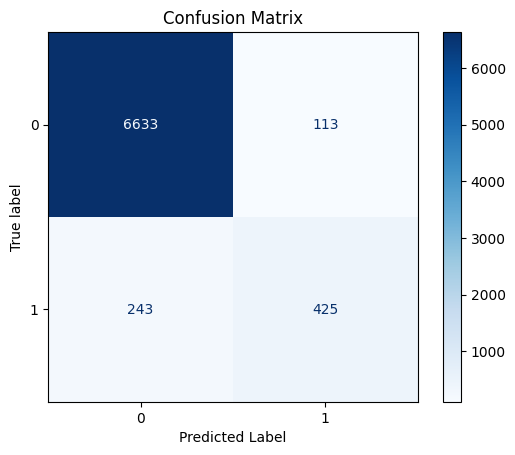

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyperparamete tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_samples': [0.5, 0.7, 1.0],
    'model__max_features': [0.5, 0.7, 1.0],
}

grid_search2 = GridSearchCV(model_pipline2,
                           param_grid=param_grid)
sb_tuned1=grid_search2.fit(X_train,y_train)
print(grid_search2.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign'])])),
                ('model',
                 BaggingClassifier(max_samples=0.5, n_estimators=200,
                                   random_state=123))])


In [ ]:
y_preds_sb_tn = sb_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_sb_tn))
auc_score_sb_tn = roc_auc_score(y_preds_sb_tn,y_test)
print(f"AUC-ROC Score: {auc_score_sb_tn:.4f}")

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6746
           1       0.78      0.62      0.69       668

    accuracy                           0.95      7414
   macro avg       0.87      0.80      0.83      7414
weighted avg       0.95      0.95      0.95      7414

AUC-ROC Score: 0.8718


In [ ]:
#training accuracy
y_preds_train_sb_tn = sb_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sb_tn))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     26760
           1       0.99      0.82      0.90      2703

    accuracy                           0.98     29463
   macro avg       0.99      0.91      0.94     29463
weighted avg       0.98      0.98      0.98     29463



Text(0.5, 0, 'Predicted Label')

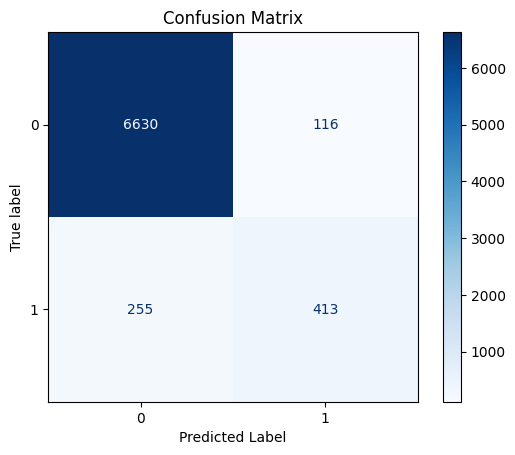

In [ ]:
cm_sb_tn = confusion_matrix(y_test, y_preds_sb_tn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sb_tn)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
model_pipline1 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',RandomForestClassifier(random_state=123))
    ]
)

model_pipline1.fit(X_train,y_train)

y_preds = model_pipline1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6746
           1       0.83      0.69      0.75       668

    accuracy                           0.96      7414
   macro avg       0.90      0.84      0.87      7414
weighted avg       0.96      0.96      0.96      7414

AUC-ROC Score: 0.9013


In [ ]:
#training accuracy
y_preds_train = model_pipline1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26760
           1       1.00      1.00      1.00      2703

    accuracy                           1.00     29463
   macro avg       1.00      1.00      1.00     29463
weighted avg       1.00      1.00      1.00     29463



Text(0.5, 0, 'Predicted Label')

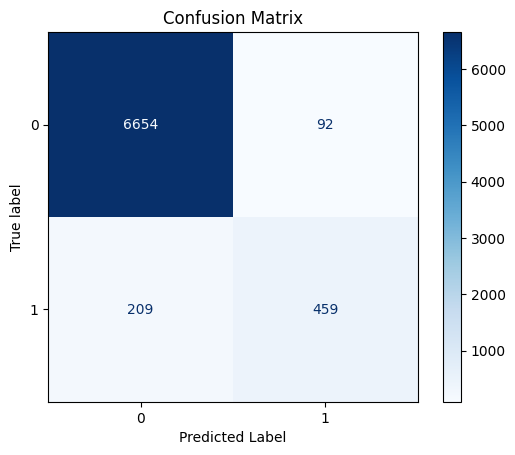

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_estimators': [50,100,200],
    'model__max_depth': [None,20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 3]
}

grid_search1 = GridSearchCV(model_pipline1,
                           param_grid=param_grid)
rf_tuned1=grid_search1.fit(X_train,y_train)
print(grid_search1.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign'])])),
                ('model',
                 RandomForestClassifier(min_samples_split=10, n_estimators=50,
                                        random_state=123))])


In [ ]:
y_preds_rf_tn = rf_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_rf_tn))
auc_score_rf_tn = roc_auc_score(y_preds_rf_tn,y_test)
print(f"AUC-ROC Score: {auc_score_rf_tn:.4f}")

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      6746
           1       0.77      0.49      0.60       668

    accuracy                           0.94      7414
   macro avg       0.86      0.74      0.79      7414
weighted avg       0.94      0.94      0.94      7414

AUC-ROC Score: 0.8631


In [ ]:
#training accuracy
y_preds_train_rf_tn = rf_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_rf_tn))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     26760
           1       0.97      0.66      0.78      2703

    accuracy                           0.97     29463
   macro avg       0.97      0.83      0.88     29463
weighted avg       0.97      0.97      0.96     29463



Text(0.5, 0, 'Predicted Label')

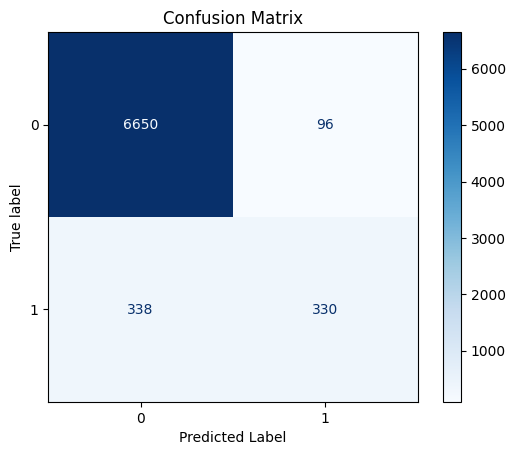

In [ ]:
cm_rf_tn = confusion_matrix(y_test, y_preds_rf_tn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_tn)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## Boosting Techniques

### Ada Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model_pipline = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',AdaBoostClassifier(random_state=123))
    ]
)

model_pipline.fit(X_train,y_train)

y_preds = model_pipline.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6746
           1       0.51      0.32      0.39       668

    accuracy                           0.91      7414
   macro avg       0.72      0.64      0.67      7414
weighted avg       0.90      0.91      0.90      7414

AUC-ROC Score: 0.7235


In [ ]:
#training accuracy
y_preds_train = model_pipline.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95     26760
           1       0.57      0.35      0.43      2703

    accuracy                           0.92     29463
   macro avg       0.75      0.66      0.69     29463
weighted avg       0.90      0.92      0.91     29463



Text(0.5, 0, 'Predicted Label')

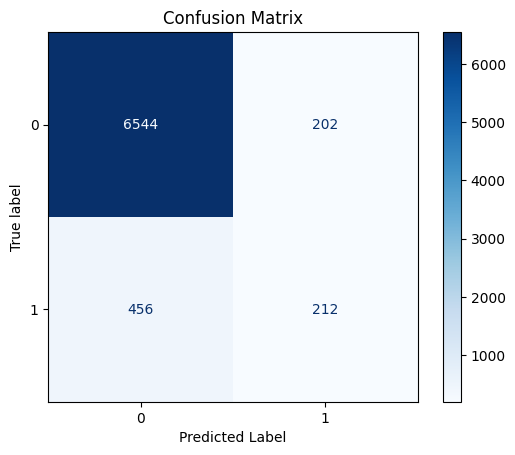

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

### XGB

In [ ]:
from xgboost import XGBClassifier
model_pipline = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',XGBClassifier(random_state=123))
    ]
)

model_pipline.fit(X_train,y_train)

y_preds = model_pipline.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6746
           1       0.69      0.54      0.61       668

    accuracy                           0.94      7414
   macro avg       0.82      0.76      0.79      7414
weighted avg       0.93      0.94      0.93      7414

AUC-ROC Score: 0.8249


In [ ]:
#training accuracy
y_preds_train = model_pipline.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     26760
           1       0.88      0.67      0.76      2703

    accuracy                           0.96     29463
   macro avg       0.92      0.83      0.87     29463
weighted avg       0.96      0.96      0.96     29463



Text(0.5, 0, 'Predicted Label')

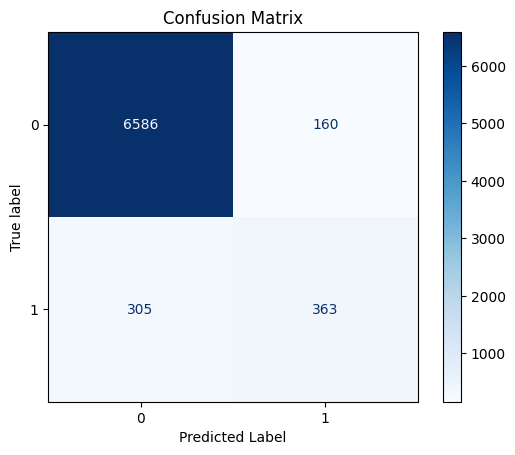

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## SVM

In [ ]:
from sklearn.svm import SVC
model_pipline4 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',SVC(random_state=123))
    ]
)

model_pipline4.fit(X_train,y_train)

y_preds = model_pipline4.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6746
           1       0.60      0.24      0.35       668

    accuracy                           0.92      7414
   macro avg       0.77      0.61      0.65      7414
weighted avg       0.90      0.92      0.90      7414

AUC-ROC Score: 0.7657


In [ ]:
#training accuracy
y_preds_train = model_pipline4.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     26760
           1       0.72      0.28      0.41      2703

    accuracy                           0.92     29463
   macro avg       0.83      0.64      0.68     29463
weighted avg       0.91      0.92      0.91     29463



In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

#### Hyperparameter tune

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__degree': [2, 3, 4]
}

grid_search2 = GridSearchCV(model_pipline4,
                           param_grid=param_grid)
svm_tuned1=grid_search2.fit(X_train,y_train)
print(grid_search2.best_estimator_)

In [ ]:
y_preds_svm_tn = svm_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_svm_tn))
auc_score_svm_tn = roc_auc_score(y_preds_svm_tn,y_test)
print(f"AUC-ROC Score: {auc_score_svm_tn:.4f}")

In [ ]:
#training accuracy
y_preds_train_svm_tn = svm_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_svm_tn))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_pipline5 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',KNeighborsClassifier(n_neighbors=2))
    ]
)

model_pipline5.fit(X_train,y_train)

y_preds = model_pipline5.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6746
           1       0.77      0.26      0.39       668

    accuracy                           0.93      7414
   macro avg       0.85      0.63      0.68      7414
weighted avg       0.92      0.93      0.91      7414

AUC-ROC Score: 0.8489


In [ ]:
#training accuracy
y_preds_train = model_pipline5.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     26760
           1       1.00      0.35      0.52      2703

    accuracy                           0.94     29463
   macro avg       0.97      0.68      0.75     29463
weighted avg       0.94      0.94      0.93     29463



Text(0.5, 0, 'Predicted Label')

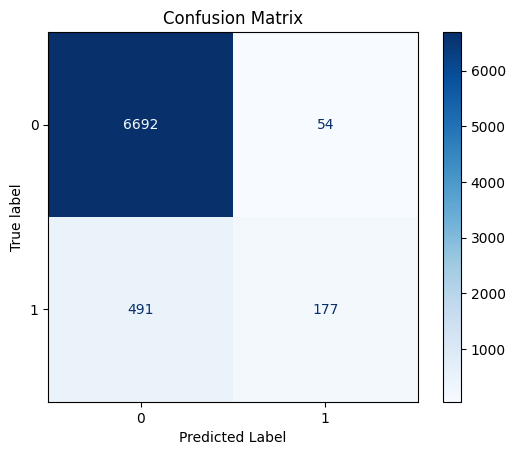

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### Hyper parameters tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_neighbors': [2,3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

grid_search4 = GridSearchCV(model_pipline5,
                           param_grid=param_grid)
knn_tuned1=grid_search4.fit(X_train,y_train)
print(grid_search4.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign'])])),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=9))])


In [ ]:
y_preds_knn_tn = knn_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_knn_tn))
auc_score_knn_tn = roc_auc_score(y_preds_knn_tn,y_test)
print(f"AUC-ROC Score: {auc_score_knn_tn:.4f}")

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6746
           1       0.62      0.29      0.40       668

    accuracy                           0.92      7414
   macro avg       0.77      0.64      0.68      7414
weighted avg       0.90      0.92      0.91      7414

AUC-ROC Score: 0.7749


In [ ]:
#training accuracy
y_preds_train_knn_tn = knn_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_knn_tn))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     26760
           1       0.71      0.34      0.46      2703

    accuracy                           0.93     29463
   macro avg       0.82      0.66      0.71     29463
weighted avg       0.92      0.93      0.91     29463



## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model_pipline6 = Pipeline(
    [
       ('preprocessor',preprocessor),
       ('model',BernoulliNB())
    ]
)

model_pipline6.fit(X_train,y_train)

y_preds = model_pipline6.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds))
auc_score = roc_auc_score(y_preds,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6746
           1       0.37      0.32      0.34       668

    accuracy                           0.89      7414
   macro avg       0.65      0.63      0.64      7414
weighted avg       0.88      0.89      0.89      7414

AUC-ROC Score: 0.6517


In [ ]:
#training accuracy
y_preds_train = model_pipline6.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     26760
           1       0.38      0.32      0.35      2703

    accuracy                           0.89     29463
   macro avg       0.66      0.63      0.64     29463
weighted avg       0.88      0.89      0.89     29463



In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

#### hyper parameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__alpha': [0.1, 0.5, 1.0],
    'model__binarize': [0.0, 0.1, 0.5],
    'model__fit_prior': [True, False]
}

grid_search7 = GridSearchCV(model_pipline6,
                           param_grid=param_grid)
nb_tuned1=grid_search7.fit(X_train,y_train)
print(grid_search7.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['education']),
                                                 ('noms',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month']),
                                                 ('quants', StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign'])])),
                ('model', BernoulliNB(binarize=0.5))])


In [ ]:
y_preds_nb_tn = nb_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_nb_tn))
auc_score_nb_tn = roc_auc_score(y_preds_nb_tn,y_test)
print(f"AUC-ROC Score: {auc_score_nb_tn:.4f}")

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6746
           1       0.38      0.32      0.35       668

    accuracy                           0.89      7414
   macro avg       0.66      0.63      0.64      7414
weighted avg       0.88      0.89      0.89      7414

AUC-ROC Score: 0.6587


In [ ]:
#training accuracy
y_preds_train = nb_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     26760
           1       0.43      0.34      0.38      2703

    accuracy                           0.90     29463
   macro avg       0.68      0.65      0.66     29463
weighted avg       0.89      0.90      0.89     29463



From initial analysis without smote Random Forest and XGB works best with data set

## Catboost

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=2000,          # Number of boosting iterations
    learning_rate=0.1,        # Learning rate
    depth=6,                  # Depth of the trees
    loss_function='Logloss',  # Loss function for binary classification
    eval_metric='AUC',        # Evaluation metric
    verbose=100,              # Print training progress every 100 iterations
    random_seed=123           # Ensures reproducibility
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=['job','marital','default','housing','loan','contact','month','education'])

# Make predictions on the test set
y_pred = model.predict(X_test)

0:	test: 0.8295722	best: 0.8295722 (0)	total: 240ms	remaining: 7m 59s
100:	test: 0.9292624	best: 0.9292624 (100)	total: 16s	remaining: 5m 1s
200:	test: 0.9327843	best: 0.9327843 (200)	total: 33.2s	remaining: 4m 56s
300:	test: 0.9350593	best: 0.9350593 (300)	total: 47.4s	remaining: 4m 27s
400:	test: 0.9370303	best: 0.9370303 (400)	total: 58.5s	remaining: 3m 53s
500:	test: 0.9382730	best: 0.9383021 (499)	total: 1m 5s	remaining: 3m 15s
600:	test: 0.9395779	best: 0.9395901 (597)	total: 1m 12s	remaining: 2m 48s
700:	test: 0.9408672	best: 0.9409151 (694)	total: 1m 17s	remaining: 2m 22s
800:	test: 0.9422568	best: 0.9422652 (787)	total: 1m 24s	remaining: 2m 6s
900:	test: 0.9431568	best: 0.9433002 (890)	total: 1m 28s	remaining: 1m 48s
1000:	test: 0.9438565	best: 0.9438663 (998)	total: 1m 33s	remaining: 1m 33s
1100:	test: 0.9448766	best: 0.9448782 (1099)	total: 1m 41s	remaining: 1m 22s
1200:	test: 0.9456189	best: 0.9456469 (1187)	total: 1m 46s	remaining: 1m 10s
1300:	test: 0.9463887	best: 0.9464

In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))
auc_score = roc_auc_score(y_pred,y_test)
print(f"AUC-ROC Score: {auc_score:.4f}")

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      6746
           1       0.70      0.53      0.61       668

    accuracy                           0.94      7414
   macro avg       0.83      0.76      0.79      7414
weighted avg       0.93      0.94      0.93      7414

AUC-ROC Score: 0.8296


In [ ]:
#training accuracy
y_preds_train_cat1 = model.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_cat1))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     26760
           1       0.91      0.68      0.78      2703

    accuracy                           0.96     29463
   macro avg       0.94      0.84      0.88     29463
weighted avg       0.96      0.96      0.96     29463



Text(0.5, 0, 'Predicted Label')

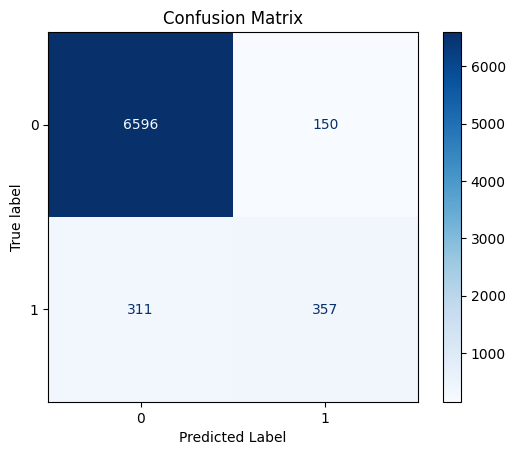

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10],
    'n_estimators': [100, 200, 300],
}

model111 = CatBoostClassifier(learning_rate=0.1, depth=6, n_estimators=100, l2_leaf_reg=1, subsample=0.8, cat_features=['job','marital','default','housing','loan','contact','month','education'])
grid_search111 = GridSearchCV(model111, param_grid, cv=3, scoring='accuracy')
nb_tuned1=grid_search111.fit(X_train,y_train)
print(grid_search111.best_estimator_)


Streaming output truncated to the last 5000 lines.
1:	learn: 0.6654191	total: 101ms	remaining: 9.99s
2:	learn: 0.6525722	total: 128ms	remaining: 8.39s
3:	learn: 0.6403865	total: 153ms	remaining: 7.51s
4:	learn: 0.6285526	total: 193ms	remaining: 7.54s
5:	learn: 0.6149058	total: 263ms	remaining: 8.51s
6:	learn: 0.6045147	total: 298ms	remaining: 8.22s
7:	learn: 0.5951670	total: 313ms	remaining: 7.51s
8:	learn: 0.5857809	total: 345ms	remaining: 7.31s
9:	learn: 0.5768022	total: 360ms	remaining: 6.84s
10:	learn: 0.5651734	total: 475ms	remaining: 8.16s
11:	learn: 0.5566630	total: 494ms	remaining: 7.74s
12:	learn: 0.5444118	total: 599ms	remaining: 8.61s
13:	learn: 0.5336355	total: 675ms	remaining: 8.97s
14:	learn: 0.5236236	total: 790ms	remaining: 9.74s
15:	learn: 0.5133251	total: 842ms	remaining: 9.68s
16:	learn: 0.5028711	total: 937ms	remaining: 10.1s
17:	learn: 0.4932289	total: 1.04s	remaining: 10.5s
18:	learn: 0.4839630	total: 1.14s	remaining: 10.8s
19:	learn: 0.4779290	total: 1.15s	remain

In [ ]:
y_preds_cat_tn = nb_tuned1.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_cat_tn))
auc_score_cat_tn = roc_auc_score(y_preds_cat_tn,y_test)
print(f"AUC-ROC Score: {auc_score_cat_tn:.4f}")

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6746
           1       0.61      0.40      0.48       668

    accuracy                           0.92      7414
   macro avg       0.78      0.69      0.72      7414
weighted avg       0.91      0.92      0.92      7414

AUC-ROC Score: 0.7784


In [ ]:
#training accuracy
y_preds_train_cat = nb_tuned1.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_cat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     26760
           1       0.69      0.45      0.54      2703

    accuracy                           0.93     29463
   macro avg       0.82      0.71      0.75     29463
weighted avg       0.92      0.93      0.92     29463



# With Smote

In [ ]:

x_train_preprocessed = preprocessor.fit_transform(X_train)
x_test_preproecessed = preprocessor.fit_transform(X_test)
smt = SMOTE(sampling_strategy=1, random_state=123)
X_train_sm, y_train_sm = smt.fit_resample(x_train_preprocessed, y_train)

In [ ]:
y_train_sm.value_counts()

subscribed
0    26760
1    26760
Name: count, dtype: int64

## Logistic Regression as Base Model

In [ ]:
model1=LogisticRegression()

model1.fit(X_train_sm,y_train_sm)
y_preds_sm1 = model1.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm1))
auc_score1 = roc_auc_score(y_preds_sm1,y_test)
print(f"AUC-ROC Score: {auc_score1:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      6746
           1       0.35      0.81      0.49       668

    accuracy                           0.85      7414
   macro avg       0.67      0.83      0.70      7414
weighted avg       0.92      0.85      0.87      7414

AUC-ROC Score: 0.6652


In [ ]:
#training accuracy
y_preds_train_sm1 = model1.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm1))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     26760
           1       0.36      0.83      0.51      2703

    accuracy                           0.85     29463
   macro avg       0.67      0.84      0.71     29463
weighted avg       0.92      0.85      0.88     29463



In [ ]:
cm1 = confusion_matrix(y_test, y_preds_sm1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

## Bagging and Ensembeled methods

## Standard Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
model21=BaggingClassifier(random_state=123)

model21.fit(X_train_sm,y_train_sm)
y_preds_sm21 = model21.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm21))
auc_score21 = roc_auc_score(y_preds_sm21,y_test)
print(f"AUC-ROC Score: {auc_score21:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      6746
           1       0.46      0.81      0.59       668

    accuracy                           0.90      7414
   macro avg       0.72      0.86      0.76      7414
weighted avg       0.93      0.90      0.91      7414

AUC-ROC Score: 0.7194


In [ ]:
  #training accuracy
y_preds_train_sm21 = model21.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm21))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26760
           1       0.98      0.98      0.98      2703

    accuracy                           1.00     29463
   macro avg       0.99      0.99      0.99     29463
weighted avg       1.00      1.00      1.00     29463



In [ ]:
cm21 = confusion_matrix(y_test, y_preds_sm21)
disp = ConfusionMatrixDisplay(confusion_matrix=cm21)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

#### hyper parameter tunning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}

grid_search6 = GridSearchCV(BaggingClassifier(random_state=123),
                           param_grid=param_grid)
sb_tuned=grid_search6.fit(X_train_sm,y_train_sm)
print(grid_search6.best_estimator_)

BaggingClassifier(max_features=0.5, n_estimators=200, random_state=123)


In [ ]:
y_preds_sm2_sb = grid_search6.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2_sb))
auc_score2_sb = roc_auc_score(y_preds_sm2_sb,y_test)
print(f"AUC-ROC Score: {auc_score2_sb:.4f}")

              precision    recall  f1-score   support

           0       0.99      0.74      0.85      6746
           1       0.26      0.93      0.41       668

    accuracy                           0.75      7414
   macro avg       0.63      0.83      0.63      7414
weighted avg       0.93      0.75      0.81      7414

AUC-ROC Score: 0.6253


In [ ]:
#training accuracy
y_preds_train_sm2_sb = sb_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2_sb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26760
           1       1.00      1.00      1.00      2703

    accuracy                           1.00     29463
   macro avg       1.00      1.00      1.00     29463
weighted avg       1.00      1.00      1.00     29463



In [ ]:
cm2_sb = confusion_matrix(y_test, y_preds_sm2_sb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2_sb)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

## Random Forest

In [ ]:
model2=RandomForestClassifier(random_state=123)

model2.fit(X_train_sm,y_train_sm)
y_preds_sm2 = model2.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2))
auc_score2 = roc_auc_score(y_preds_sm2,y_test)
print(f"AUC-ROC Score: {auc_score2:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.89      0.94      6746
           1       0.44      0.84      0.58       668

    accuracy                           0.89      7414
   macro avg       0.71      0.87      0.76      7414
weighted avg       0.93      0.89      0.90      7414

AUC-ROC Score: 0.7109


In [ ]:
#training accuracy
y_preds_train_sm2 = model2.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26760
           1       1.00      1.00      1.00      2703

    accuracy                           1.00     29463
   macro avg       1.00      1.00      1.00     29463
weighted avg       1.00      1.00      1.00     29463



In [ ]:
cm2 = confusion_matrix(y_test, y_preds_sm2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

#### Hyperparameter tune

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None,20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

grid_search9 = GridSearchCV(RandomForestClassifier(random_state=123),
                           param_grid=param_grid)
rf_tuned=grid_search9.fit(X_train_sm,y_train_sm)
print(grid_search9.best_estimator_)

RandomForestClassifier(random_state=123)


In [ ]:
y_preds_sm2_rf = grid_search9.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2_rf))
auc_score2_rf = roc_auc_score(y_preds_sm2_rf,y_test)
print(f"AUC-ROC Score: {auc_score2_rf:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.89      0.94      6746
           1       0.44      0.84      0.58       668

    accuracy                           0.89      7414
   macro avg       0.71      0.87      0.76      7414
weighted avg       0.93      0.89      0.90      7414

AUC-ROC Score: 0.7109


In [ ]:
#training accuracy
y_preds_train_sm2_rf = rf_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26760
           1       1.00      1.00      1.00      2703

    accuracy                           1.00     29463
   macro avg       1.00      1.00      1.00     29463
weighted avg       1.00      1.00      1.00     29463



## Boosting Methods

### XGB

In [ ]:
from xgboost import XGBClassifier
model3=XGBClassifier(random_state=123)

model3.fit(X_train_sm,y_train_sm)
y_preds_sm3 = model3.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm3))
auc_score3 = roc_auc_score(y_preds_sm3,y_test)
print(f"AUC-ROC Score: {auc_score3:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      6746
           1       0.42      0.72      0.53       668

    accuracy                           0.89      7414
   macro avg       0.70      0.81      0.73      7414
weighted avg       0.92      0.89      0.90      7414

AUC-ROC Score: 0.6954


In [ ]:
#training accuracy
y_preds_train_sm3 = model3.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm3))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     26760
           1       0.74      0.74      0.74      2703

    accuracy                           0.95     29463
   macro avg       0.86      0.86      0.86     29463
weighted avg       0.95      0.95      0.95     29463



In [ ]:
cm3 = confusion_matrix(y_test, y_preds_sm3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

### Ada Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model5=AdaBoostClassifier(random_state=123)

model5.fit(X_train_sm,y_train_sm)
y_preds_sm5 = model5.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm5))
auc_score5 = roc_auc_score(y_preds_sm5,y_test)
print(f"AUC-ROC Score: {auc_score5:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      6746
           1       0.25      0.88      0.38       668

    accuracy                           0.75      7414
   macro avg       0.61      0.80      0.61      7414
weighted avg       0.92      0.75      0.80      7414

AUC-ROC Score: 0.6144


In [ ]:
#training accuracy
y_preds_train_sm5 = model5.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm5))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     26760
           1       0.41      0.71      0.52      2703

    accuracy                           0.88     29463
   macro avg       0.69      0.80      0.73     29463
weighted avg       0.92      0.88      0.89     29463



Text(0.5, 0, 'Predicted Label')

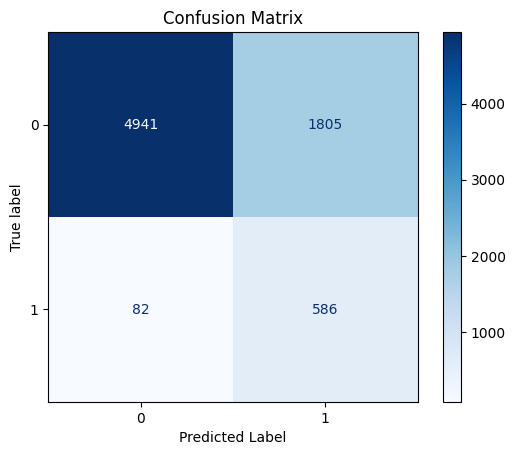

In [ ]:
cm5 = confusion_matrix(y_test, y_preds_sm5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

## SVM

In [ ]:
from sklearn.svm import SVC
model6=SVC(random_state=123)

model6.fit(X_train_sm,y_train_sm)
y_preds_sm6 = model6.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm6))
auc_score6 = roc_auc_score(y_preds_sm6,y_test)
print(f"AUC-ROC Score: {auc_score6:.4f}")

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      6746
           1       0.38      0.85      0.53       668

    accuracy                           0.86      7414
   macro avg       0.68      0.86      0.72      7414
weighted avg       0.93      0.86      0.88      7414

AUC-ROC Score: 0.6830


In [ ]:
#training accuracy
y_preds_train_sm6 = model6.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm6))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92     26760
           1       0.41      0.91      0.57      2703

    accuracy                           0.87     29463
   macro avg       0.70      0.89      0.75     29463
weighted avg       0.94      0.87      0.89     29463



In [ ]:
cm6 = confusion_matrix(y_test, y_preds_sm6)
disp = ConfusionMatrixDisplay(confusion_matrix=cm6)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

#### hyper parameter tuned

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4]
}

grid_search10 = GridSearchCV(SVC(random_state=123),
                           param_grid=param_grid)
svm_tuned=grid_search10.fit(X_train_sm,y_train_sm)
print(grid_search10.best_estimator_)

In [ ]:
y_preds_sm2_svm = grid_search10.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm2_svm))
auc_score2_svm = roc_auc_score(y_preds_sm2_svm,y_test)
print(f"AUC-ROC Score: {auc_score2_svm:.4f}")

In [ ]:
#training accuracy
y_preds_train_sm2_svm = grid_search10.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm2_svm))

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model7=KNeighborsClassifier(n_neighbors=2)

model7.fit(X_train_sm,y_train_sm)
y_preds_sm7 = model7.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm7))
auc_score7 = roc_auc_score(y_preds_sm7,y_test)
print(f"AUC-ROC Score: {auc_score7:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6746
           1       0.67      0.73      0.70       668

    accuracy                           0.94      7414
   macro avg       0.82      0.85      0.84      7414
weighted avg       0.95      0.94      0.94      7414

AUC-ROC Score: 0.8232


In [ ]:
#training accuracy
y_preds_train_sm7 = model7.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm7))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26760
           1       1.00      1.00      1.00      2703

    accuracy                           1.00     29463
   macro avg       1.00      1.00      1.00     29463
weighted avg       1.00      1.00      1.00     29463



Text(0.5, 0, 'Predicted Label')

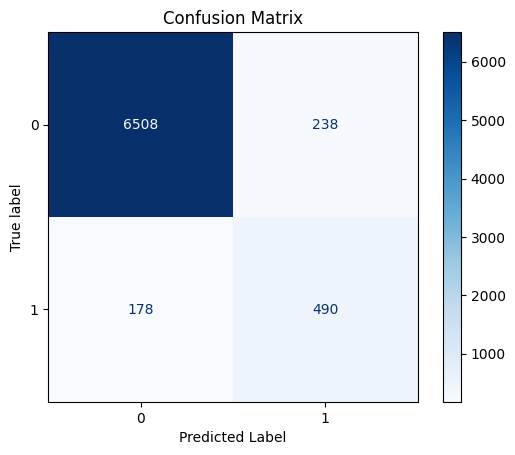

In [ ]:
cm7 = confusion_matrix(y_test, y_preds_sm7)
disp = ConfusionMatrixDisplay(confusion_matrix=cm7)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

#### hyper parameter tune

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
   'n_neighbors': [2,3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search2 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid)
knn_tuned=grid_search2.fit(X_train_sm,y_train_sm)
print(grid_search2.best_estimator_)

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')


In [ ]:
y_preds_sm7_tn = knn_tuned.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm7_tn))
auc_score7_tn = roc_auc_score(y_preds_sm7_tn,y_test)
print(f"AUC-ROC Score: {auc_score7_tn:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6746
           1       0.69      0.72      0.70       668

    accuracy                           0.94      7414
   macro avg       0.83      0.84      0.84      7414
weighted avg       0.95      0.94      0.95      7414

AUC-ROC Score: 0.8287


In [ ]:
#training accuracy
y_preds_train_sm7_tn = knn_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm7_tn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26760
           1       1.00      1.00      1.00      2703

    accuracy                           1.00     29463
   macro avg       1.00      1.00      1.00     29463
weighted avg       1.00      1.00      1.00     29463



In [ ]:
cm7_tn = confusion_matrix(y_test, y_preds_sm7_tn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm7_tn)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

## Naive Bias

In [ ]:
from sklearn.naive_bayes import BernoulliNB
model8=BernoulliNB()

model8.fit(X_train_sm,y_train_sm)
y_preds_sm8 = model8.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm8))
auc_score8 = roc_auc_score(y_preds_sm8,y_test)
print(f"AUC-ROC Score: {auc_score8:.4f}")


              precision    recall  f1-score   support

           0       0.96      0.74      0.84      6746
           1       0.21      0.72      0.33       668

    accuracy                           0.74      7414
   macro avg       0.59      0.73      0.58      7414
weighted avg       0.90      0.74      0.79      7414

AUC-ROC Score: 0.5883


In [ ]:
#training accuracy
y_preds_train_sm8 = model8.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm8))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     26760
           1       0.22      0.72      0.33      2703

    accuracy                           0.74     29463
   macro avg       0.59      0.73      0.58     29463
weighted avg       0.89      0.74      0.79     29463



In [ ]:
cm8 = confusion_matrix(y_test, y_preds_sm8)
disp = ConfusionMatrixDisplay(confusion_matrix=cm8)
disp.plot(cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
disp.ax_.set_xlabel('Predicted Label')

Text(0.5, 0, 'Predicted Label')

#### hyper parameter tuned


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'binarize': [0.0, 0.1, 0.5],
    'fit_prior': [True, False]
}

grid_search11 = GridSearchCV(estimator=BernoulliNB(), param_grid=param_grid)
nb_tuned=grid_search11.fit(X_train_sm,y_train_sm)
print(grid_search11.best_estimator_)

BernoulliNB(alpha=0.1)


In [ ]:
y_preds_sm7_nb = nb_tuned.predict(x_test_preproecessed)
print(classification_report(y_true=y_test,y_pred=y_preds_sm7_nb))
auc_score7_nb = roc_auc_score(y_preds_sm7_nb,y_test)
print(f"AUC-ROC Score: {auc_score7_nb:.4f}")

              precision    recall  f1-score   support

           0       0.96      0.74      0.84      6746
           1       0.21      0.72      0.33       668

    accuracy                           0.74      7414
   macro avg       0.59      0.73      0.58      7414
weighted avg       0.90      0.74      0.79      7414

AUC-ROC Score: 0.5886


In [ ]:
#training accuracy
y_preds_train_sm7_nb = nb_tuned.predict(x_train_preprocessed)
print(classification_report(y_true=y_train,y_pred=y_preds_train_sm7_nb))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84     26760
           1       0.22      0.72      0.33      2703

    accuracy                           0.74     29463
   macro avg       0.59      0.73      0.58     29463
weighted avg       0.89      0.74      0.79     29463



In [ ]:
#saving pickel model,knn_tuned, rf_tuned,rf_tuned1
import pickle
pickle.dump(knn_tuned, open('knn_tuned.pkl', 'wb'))
pickle.dump(rf_tuned, open('rf_tuned.pkl', 'wb'))
pickle.dump(rf_tuned1, open('rf_tuned1.pkl', 'wb'))

In [ ]:
#save above model in same directory colab
from google.colab import files
files.download('knn_tuned.pkl')
files.download('rf_tuned.pkl')
files.download('rf_tuned1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
from google.colab import files
pickle.dump(model_pipline1, open('model_pipline1.pkl', 'wb'))
files.download('model_pipline1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cat Boost with smote

In [ ]:
X_train[noms] = X_train[noms].astype('category')
X_train[ords] = X_train[ords].astype('category')
X_test[noms]=X_test[noms].astype('category')
X_test[ords]=X_test[ords].astype('category')

In [ ]:
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=['job','marital','default','housing','loan','contact','month','education'], random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=2000,          # Number of boosting iterations
    learning_rate=0.1,        # Learning rate
    depth=6,                  # Depth of the trees
    loss_function='Logloss',  # Loss function for binary classification
    eval_metric='AUC',        # Evaluation metric
    verbose=100,              # Print training progress every 100 iterations
    random_seed=123           # Ensures reproducibility
)

# Train the model
model_cat.fit(X_resampled , y_resampled, eval_set=(X_test, y_test), cat_features=['job','marital','default','housing','loan','contact','month','education'],)



0:	test: 0.8651758	best: 0.8651758 (0)	total: 452ms	remaining: 15m 4s
100:	test: 0.9207621	best: 0.9207621 (100)	total: 19.9s	remaining: 6m 14s
200:	test: 0.9253326	best: 0.9253326 (200)	total: 38.1s	remaining: 5m 40s
300:	test: 0.9297060	best: 0.9297313 (299)	total: 1m 2s	remaining: 5m 55s
400:	test: 0.9323314	best: 0.9323314 (400)	total: 1m 27s	remaining: 5m 48s
500:	test: 0.9349359	best: 0.9349359 (500)	total: 1m 45s	remaining: 5m 16s
600:	test: 0.9370272	best: 0.9370272 (600)	total: 1m 55s	remaining: 4m 29s
700:	test: 0.9390098	best: 0.9390098 (700)	total: 2m 8s	remaining: 3m 58s
800:	test: 0.9403512	best: 0.9403754 (799)	total: 2m 20s	remaining: 3m 30s
900:	test: 0.9417654	best: 0.9417654 (900)	total: 2m 32s	remaining: 3m 5s
1000:	test: 0.9429800	best: 0.9429804 (999)	total: 2m 46s	remaining: 2m 46s
1100:	test: 0.9442440	best: 0.9442440 (1100)	total: 3m 8s	remaining: 2m 33s
1200:	test: 0.9454310	best: 0.9454327 (1198)	total: 3m 28s	remaining: 2m 18s
1300:	test: 0.9463310	best: 0.9

NameError: name 'model' is not defined

In [ ]:
# Make predictions on the test set
y_pred_cat = model_cat.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_pred_cat))
auc_score_cat1 = roc_auc_score(y_pred_cat,y_test)
print(f"AUC-ROC Score: {auc_score_cat1:.4f}")

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6746
           1       0.65      0.63      0.64       668

    accuracy                           0.94      7414
   macro avg       0.80      0.80      0.80      7414
weighted avg       0.94      0.94      0.94      7414

AUC-ROC Score: 0.8048


In [ ]:
#training accuracy
y_preds_train_cat1 = model_cat.predict(X_train)
print(classification_report(y_true=y_train,y_pred=y_preds_train_cat1))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     26760
           1       0.83      0.77      0.80      2703

    accuracy                           0.96     29463
   macro avg       0.90      0.88      0.89     29463
weighted avg       0.96      0.96      0.96     29463



#### hyper parameter

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10],
    'n_estimators': [100, 200, 300],
}

model222 = CatBoostClassifier(learning_rate=0.1, depth=6, n_estimators=100, l2_leaf_reg=1, subsample=0.8, cat_features=['job','marital','default','housing','loan','contact','month','education'])
grid_search222 = GridSearchCV(model222, param_grid, cv=3, scoring='accuracy')
nb_tuned1=grid_search222.fit(X_resampled , y_resampled)
print(grid_search222.best_estimator_)


Streaming output truncated to the last 5000 lines.
1:	learn: 0.6720006	total: 287ms	remaining: 28.4s
2:	learn: 0.6620485	total: 430ms	remaining: 28.3s
3:	learn: 0.6521653	total: 567ms	remaining: 27.8s
4:	learn: 0.6421501	total: 721ms	remaining: 28.1s
5:	learn: 0.6326789	total: 859ms	remaining: 27.8s
6:	learn: 0.6236072	total: 1.02s	remaining: 28.1s
7:	learn: 0.6146608	total: 1.16s	remaining: 27.8s
8:	learn: 0.6065776	total: 1.3s	remaining: 27.7s
9:	learn: 0.5981753	total: 1.44s	remaining: 27.5s
10:	learn: 0.5904069	total: 1.59s	remaining: 27.4s
11:	learn: 0.5828206	total: 1.74s	remaining: 27.3s
12:	learn: 0.5749785	total: 1.9s	remaining: 27.4s
13:	learn: 0.5673388	total: 2.06s	remaining: 27.4s
14:	learn: 0.5605993	total: 2.21s	remaining: 27.2s
15:	learn: 0.5542190	total: 2.29s	remaining: 26.3s
16:	learn: 0.5473339	total: 2.45s	remaining: 26.4s
17:	learn: 0.5413590	total: 2.59s	remaining: 26.2s
18:	learn: 0.5352081	total: 2.72s	remaining: 25.9s
19:	learn: 0.5290807	total: 2.85s	remainin

In [ ]:
y_preds_cat_tn1 = grid_search222.predict(X_test)
print(classification_report(y_true=y_test,y_pred=y_preds_cat_tn1))
auc_score_cat_tn1 = roc_auc_score(y_preds_cat_tn1,y_test)
print(f"AUC-ROC Score: {auc_score_cat_tn1:.4f}")

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6746
           1       0.69      0.71      0.70       668

    accuracy                           0.94      7414
   macro avg       0.83      0.84      0.83      7414
weighted avg       0.95      0.94      0.95      7414

AUC-ROC Score: 0.8300


In [ ]:
#training accuracy
y_preds_train_cat1 = grid_search222.predict(X_resampled)
print(classification_report(y_true=y_resampled,y_pred=y_preds_train_cat1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26760
           1       0.99      0.99      0.99     26760

    accuracy                           0.99     53520
   macro avg       0.99      0.99      0.99     53520
weighted avg       0.99      0.99      0.99     53520



# Best model performance

In [ ]:
best_model=model_pipline1.named_steps['model']

In [ ]:
importances = best_model.feature_importances_

In [ ]:
feature_names = model_pipline1.named_steps['preprocessor'].get_feature_names_out()


In [ ]:
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
for nom in noms:
    nom_features = [col for col in importance_df['feature'] if col.startswith(f'noms__{nom}')]
    summed_importance = importance_df[importance_df['feature'].isin(nom_features)]['importance'].sum()
    aggregated_row = pd.DataFrame({'feature': [nom], 'importance': [summed_importance]})
    importance_df = pd.concat([importance_df[~importance_df['feature'].isin(nom_features)], aggregated_row])
importance_df = importance_df.sort_values(by='importance', ascending=False)


In [ ]:
# remove the name.replace('noms__', '').replace('ordinal__', '').replace('quants__', '') in column fetures in importnce df

feature_names1 = [name.replace('noms__', '').replace('ordinal__', '').replace('quants__', '') for name in importance_df["feature"]]
importance_df["feature"]=feature_names1

In [ ]:
import plotly.express as px
importance_df['importance_percentage'] = 100 * importance_df['importance'] / importance_df['importance'].sum()

fig = px.bar(
    importance_df,
    y='feature',
    x='importance_percentage',
    orientation='h',
    labels={'importance_percentage': 'Variable Importance (%)', 'feature': 'Variables'},
    title='Variable Importance Plot'
)

fig.update_layout(
    yaxis=dict(autorange="reversed"),
    xaxis_title='Variable Importance (%)',
    yaxis_title='Variables',
    height=600,
    width=1000
)


fig.update_traces(texttemplate='%{x:.2f}%', textposition='inside')

fig.show()

removing defualt and modelling again not increasing the accuracy

## Shap Analysis

In [ ]:
X_train_preprocessed=model_pipline1.named_steps['preprocessor'].transform(X_train)

In [ ]:
#X_train_preprocessed as data frame and column names is in feature_names
feature_names2 = [name.replace('noms__', '').replace('ordinal__', '').replace('quants__', '') for name in feature_names]

X_train_preprocessed1 = pd.DataFrame(X_train_preprocessed, columns=feature_names2)
X_train_preprocessed1

education  job_admin.  job_blue-collar  job_entrepreneur  \
0            1.0         0.0              0.0               0.0   
1            1.0         0.0              0.0               0.0   
2            2.0         0.0              0.0               0.0   
3            1.0         0.0              0.0               0.0   
4            2.0         0.0              0.0               0.0   
...          ...         ...              ...               ...   
29458        3.0         0.0              0.0               0.0   
29459        1.0         1.0              0.0               0.0   
29460        1.0         0.0              1.0               0.0   
29461        2.0         0.0              0.0               0.0   
29462        1.0         0.0              1.0               0.0   

       job_housemaid  job_management  job_retired  job_self-employed  \
0                0.0             0.0          0.0                0.0   
1                0.0             1.0          0.0                0.0   
2                0.0             1.0          0.0                0.0   
3                0.0             0.0          0.0                0.0   
4                0.0             0.0          0.0                1.0   
...              ...             ...          ...                ...   
29458            0.0             0.0          0.0                0.0   
29459            0.0             0.0          0.0                0.0   
29460            0.0             0.0          0.0                0.0   
29461            0.0             1.0          0.0                0.0   
29462            0.0             0.0          0.0                0.0   

       job_services  job_student  ...  month_jun  month_mar  month_may  \
0               0.0          1.0  ...        0.0        0.0        1.0   
1               0.0          0.0  ...        0.0        0.0        0.0   
2               0.0          0.0  ...        0.0        0.0        0.0   
3               1.0          0.0  ...        0.0        1.0        0.0   
4               0.0          0.0  ...        0.0        0.0        0.0   
...             ...          ...  ...        ...        ...        ...   
29458           0.0          0.0  ...        0.0        0.0        0.0   
29459           0.0          0.0  ...        0.0        0.0        0.0   
29460           0.0          0.0  ...        0.0        0.0        1.0   
29461           0.0          0.0  ...        0.0        0.0        0.0   
29462           0.0          0.0  ...        0.0        0.0        0.0   

       month_nov  month_oct  month_sep       age   balance  duration  campaign  
0            0.0        0.0        0.0 -1.341336 -0.213168  0.285901 -0.279605  
1            0.0        0.0        0.0  1.438399 -0.366778 -0.659544  0.920657  
2            0.0        1.0        0.0  0.575723 -0.435786  0.956862 -0.579670  
3            0.0        0.0        0.0  0.863281 -0.435786  1.646884 -0.279605  
4            1.0        0.0        0.0 -0.957924 -0.363792  0.930176  0.320526  
...          ...        ...        ...       ...       ...       ...       ...  
29458        0.0        0.0        0.0  0.479870 -0.435786  0.327836 -0.579670  
29459        0.0        0.0        0.0 -0.095248 -0.244686 -0.545176  0.020461  
29460        0.0        0.0        0.0 -0.670365 -0.461000 -0.331688 -0.579670  
29461        0.0        0.0        0.0 -0.862071 -0.412230 -0.137262  1.520788  
29462        0.0        0.0        0.0 -0.670365 -0.313694  7.411049 -0.579670  

[29463 rows x 41 columns]

In [ ]:
#y_train as dataframe
y_train1 = pd.DataFrame(y_train, columns=['y'])

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_preprocessed1)

In [ ]:
file_path1 = '/content/drive/My Drive/Colab Notebooks/Final Project Stat Learning 2/3d_array1.npz'

# Save the 3D array to a .npz file
np.savez(file_path1, array=shap_values.values)

### Waterfall plot

In [ ]:
explanation1 = shap.Explanation(
    values=shap_values.values[0][:,0],
    base_values=explainer.expected_value[0],
    data=X_train_preprocessed1.iloc[0],
    feature_names=X_train_preprocessed1.columns
)

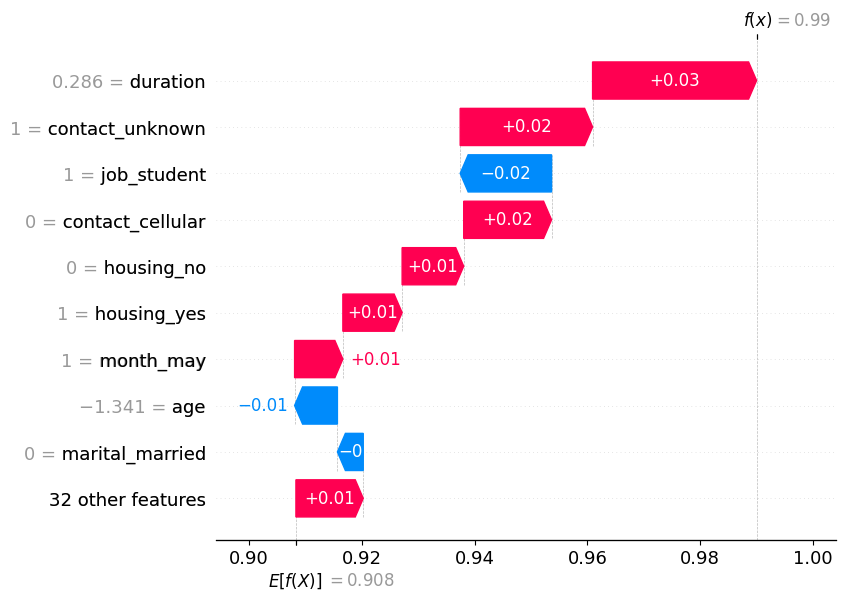

In [ ]:
shap.plots.waterfall(explanation1)

In [ ]:
explanation2 = shap.Explanation(
    values=shap_values.values[0][:,1],
    base_values=explainer.expected_value[1],
    data=X_train_preprocessed1.iloc[0],
    feature_names=X_train_preprocessed1.columns
)

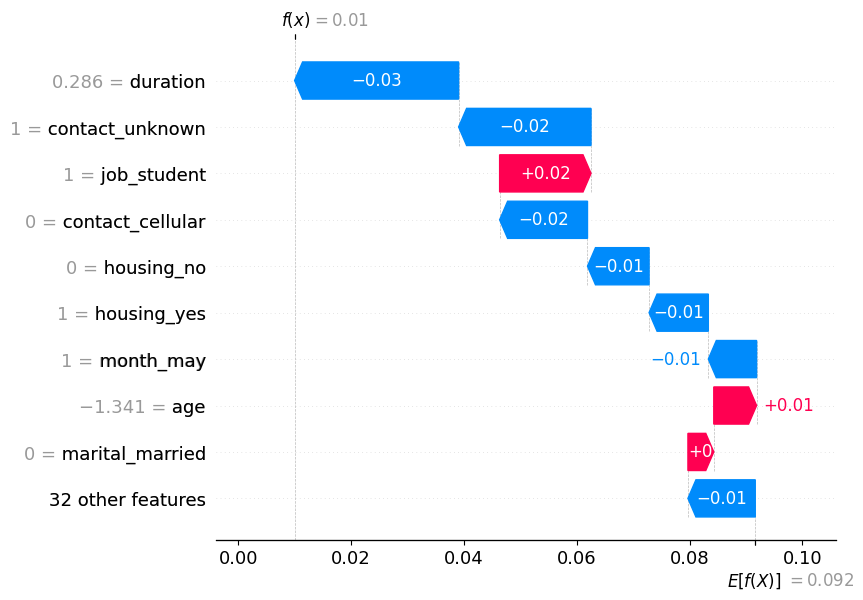

In [ ]:
shap.plots.waterfall(explanation2)

### force plots

In [ ]:
from IPython.display import display, HTML

force_plot =shap.force_plot(
    base_value=explainer.expected_value[0],  # Base value for class 1
    shap_values=shap_values.values[0:1000,:,0],  # SHAP values for the first 5 instances
    features=X_train_preprocessed1.iloc[:1000],  # Feature values for the first 5 instances
    feature_names=X_train_preprocessed1.columns.tolist(),  # Feature names
    out_names="Class 0 Prediction",  # Label for the output
)
html_path = '/content/force_plot1.html'

shap.save_html(html_path, force_plot)

# Display the HTML file in Colab
display(HTML(html_path))

In [ ]:
#for calss 1
force_plot1=shap.force_plot(
    base_value=explainer.expected_value[0],  # Base value for class 1
    shap_values=shap_values.values[0:1000,:,0],  # SHAP values for the first 5 instances
    features=X_train_preprocessed1.iloc[:1000],  # Feature values for the first 5 instances
    feature_names=X_train_preprocessed1.columns.tolist(),  # Feature names
    out_names="Class 1 Prediction",  # Label for the output
)
html_path1 = '/content/force_plot1.html'

shap.save_html(html_path1, force_plot1)

# Display the HTML file in Colab
display(HTML(html_path1))

### beeeswam plots

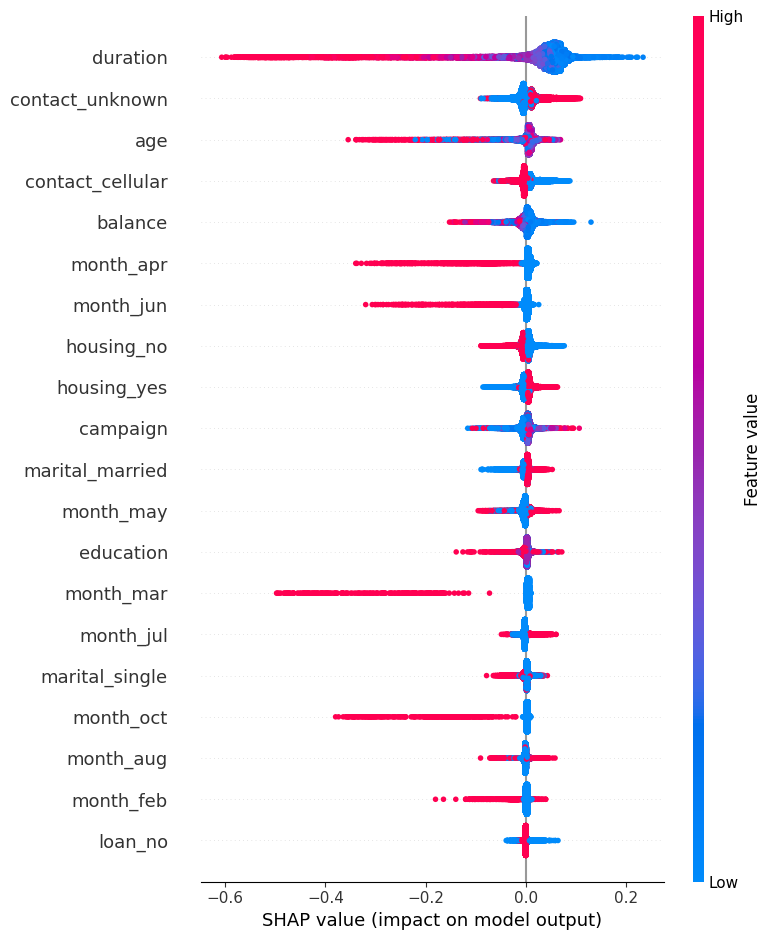

In [ ]:
shap.summary_plot(shap_values.values[:,:,0], X_train_preprocessed1)

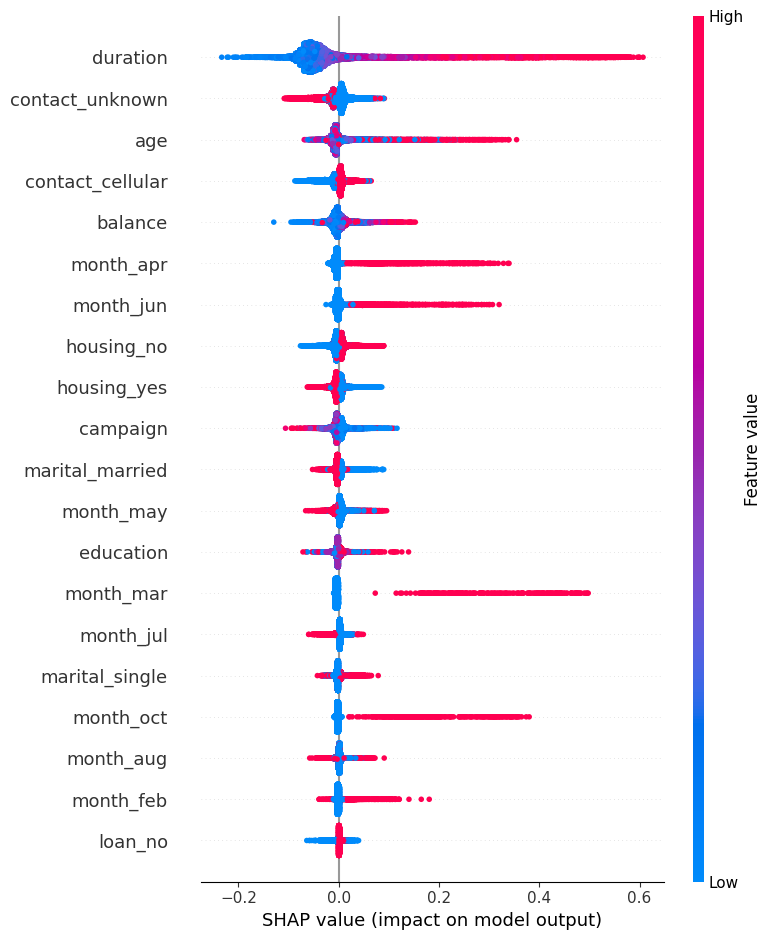

In [ ]:
shap.summary_plot(shap_values.values[:,:,1], X_train_preprocessed1)

### violin plots

In [ ]:
#for class 0
shap_df0 = pd.DataFrame({
    'Feature': np.repeat(X_train_preprocessed1.columns, len(X_train_preprocessed1)),
    'SHAP Value': np.concatenate(shap_values.values[:,:,0], axis=0),
    'Sample': np.tile(np.arange(len(X_train_preprocessed1)), len(X_train_preprocessed1.columns))
})

# Print the first few rows of the DataFrame
print(shap_df.head())

NameError: name 'shap_df' is not defined

In [ ]:
plt.figure(figsize=(12, 8))

# Create the violin plot
sns.violinplot(x='Feature', y='SHAP Value', data=shap_df0, scale='width', inner='quartile')

# Customize the plot
plt.title('Violin Plot of SHAP Values by Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('SHAP Value')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#for class 0
shap_df1 = pd.DataFrame({
    'Feature': np.repeat(X_train_preprocessed1.columns, len(X_train_preprocessed1)),
    'SHAP Value': np.concatenate(shap_values.values[:,:,1], axis=0),
    'Sample': np.tile(np.arange(len(X_train_preprocessed1)), len(X_train_preprocessed1.columns))
})

# Print the first few rows of the DataFrame
print(shap_df.head())

In [ ]:
plt.figure(figsize=(12, 8))

# Create the violin plot
sns.violinplot(x='Feature', y='SHAP Value', data=shap_df1, scale='width', inner='quartile')

# Customize the plot
plt.title('Violin Plot of SHAP Values by Feature')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('SHAP Value')

# Show the plot
plt.tight_layout()
plt.show()

# NN Fit


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras

In [ ]:
x_train_preprocessed = preprocessor.fit_transform(X_train)
x_test_preproecessed = preprocessor.fit_transform(X_test)

In [ ]:
y_train_sm=keras.utils.to_categorical(y_train_sm )

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=x_train_preprocessed.shape[1], activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,762 (53.76 KB)

 Trainable params: 13,762 (53.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train_sm, y_train_sm , epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6408 - loss: 0.6380 - val_accuracy: 0.8437 - val_loss: 0.5638
Epoch 2/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8398 - loss: 0.4137 - val_accuracy: 0.8597 - val_loss: 0.4789
Epoch 3/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8480 - loss: 0.3736 - val_accuracy: 0.8828 - val_loss: 0.4201
Epoch 4/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8544 - loss: 0.3543 - val_accuracy: 0.8729 - val_loss: 0.4229
Epoch 5/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8587 - loss: 0.3407 - val_accuracy: 0.8826 - val_loss: 0.3880
Epoch 6/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8566 - loss: 0.3391 - val_accuracy: 0.8642 - val_loss: 0.4102
Epoch 7/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8626 - loss: 0.3291 - val_accuracy: 0.8840 - val_loss: 0.3671
Epoch 8/10
1338/1338 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8649 - loss: 0.3235 - 

In [ ]:
y_tf = model.predict(x_test_preproecessed)

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
pred_array=model.predict(x_test_preproecessed)
predicted_classes = np.argmax(pred_array, axis=1)
predicted_classes

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([1, 0, 1, ..., 1, 0, 0])

In [ ]:
print("Accuracy Score :",accuracy_score(y_true=y_test,y_pred=predicted_classes))
print("F1 Score :",f1_score(y_true=y_test,y_pred=predicted_classes))
print(f"AUC-ROC Score: {roc_auc_score(predicted_classes,y_test):.4f}")
print("Classification Report")
print(classification_report(y_true=y_test,y_pred=predicted_classes))

Accuracy Score : 0.8622875640679795
F1 Score : 0.5181689476168003
AUC-ROC Score: 0.6792
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      6746
           1       0.38      0.82      0.52       668

    accuracy                           0.86      7414
   macro avg       0.68      0.84      0.72      7414
weighted avg       0.93      0.86      0.88      7414

